# Movie recommendation on Amazon SageMaker with Factorization Machines

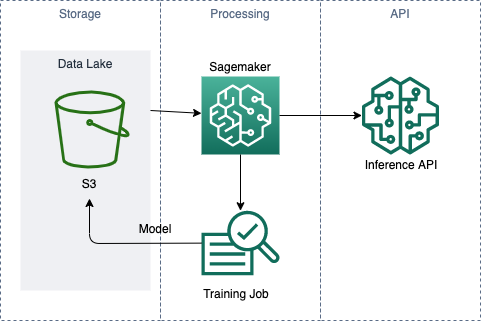

## 1) Install dependencies

In [ ]:
!pip install simplejson

## 2) Download ml-100k dataset

In [ ]:
!wget http://files.grouplens.org/datasets/movielens/ml-100k.zip
!unzip -o ml-100k.zip

In [ ]:
%cd ml-100k
!shuf ua.base -o ua.base.shuffled
!head -10 ua.base.shuffled

In [ ]:
!head -10 ua.test

In [ ]:
import sagemaker
import sagemaker.amazon.common as smac
from sagemaker import get_execution_role
from sagemaker.predictor import json_deserializer

import boto3, csv, io, json
import numpy as np
from scipy.sparse import lil_matrix

## 3) Build training set and test set

In [ ]:
nbUsers=943
nbMovies=1682
nbFeatures=nbUsers+nbMovies

nbRatingsTrain=90570
nbRatingsTest=9430

In [ ]:
# For each user, build a list of rated movies.
# We'd need this to add random negative samples.
moviesByUser = {}
for userId in range(nbUsers):
    moviesByUser[str(userId)]=[]
 
with open('ua.base.shuffled','r') as f:
    samples=csv.reader(f,delimiter='\t')
    for userId,movieId,rating,timestamp in samples:
        moviesByUser[str(int(userId)-1)].append(int(movieId)-1) 

In [ ]:
def loadDataset(filename, lines, columns):
    # Features are one-hot encoded in a sparse matrix
    X = lil_matrix((lines, columns)).astype('float32')
    # Labels are stored in a vector
    Y = []
    line=0
    with open(filename,'r') as f:
        samples=csv.reader(f,delimiter='\t')
        for userId,movieId,rating,timestamp in samples:
            X[line,int(userId)-1] = 1
            X[line,int(nbUsers)+int(movieId)-1] = 1
            if int(rating) >= 4:
                Y.append(1)
            else:
                Y.append(0)
            line=line+1
            
    Y=np.array(Y).astype('float32')
    return X,Y

In [ ]:
X_train, Y_train = loadDataset('ua.base.shuffled', nbRatingsTrain, nbFeatures)
X_test, Y_test = loadDataset('ua.test',nbRatingsTest,nbFeatures)

In [ ]:
print(X_train.shape)
print(Y_train.shape)
assert X_train.shape == (nbRatingsTrain, nbFeatures)
assert Y_train.shape == (nbRatingsTrain, )
zero_labels = np.count_nonzero(Y_train)
print("Training labels: %d zeros, %d ones" % (zero_labels, nbRatingsTrain-zero_labels))

print(X_test.shape)
print(Y_test.shape)
assert X_test.shape  == (nbRatingsTest, nbFeatures)
assert Y_test.shape  == (nbRatingsTest, )
zero_labels = np.count_nonzero(Y_test)
print("Test labels: %d zeros, %d ones" % (zero_labels, nbRatingsTest-zero_labels))

## 4) Convert to protobuf and save to S3

In [ ]:
import simplejson
import os
with open('/opt/ml/metadata/resource-metadata.json') as fh:
    metadata = simplejson.loads(fh.read())
accountid = metadata['ResourceArn'].split(':')[4]

%set_env accountid={accountid}
%set_env bucket_name=lab-{accountid}
bucket_name = os.getenv('bucket_name')
print(bucket_name)

bucket = bucket_name
prefix = 'sagemaker/fm-movielens'

train_key      = 'train.protobuf'
train_prefix   = '{}/{}'.format(prefix, 'train3')

test_key       = 'test.protobuf'
test_prefix    = '{}/{}'.format(prefix, 'test3')

output_prefix  = 's3://{}/{}/output'.format(bucket, prefix)

In [ ]:
def writeDatasetToProtobuf(X, Y, bucket, prefix, key):
    buf = io.BytesIO()
    smac.write_spmatrix_to_sparse_tensor(buf, X, Y)
    buf.seek(0)
    obj = '{}/{}'.format(prefix, key)
    boto3.resource('s3').Bucket(bucket).Object(obj).upload_fileobj(buf)
    return 's3://{}/{}'.format(bucket,obj)
    
train_data = writeDatasetToProtobuf(X_train, Y_train, bucket, train_prefix, train_key)    
test_data  = writeDatasetToProtobuf(X_test, Y_test, bucket, test_prefix, test_key)    
  
print(train_data)
print(test_data)
print('Output: {}'.format(output_prefix))

## 5) Run training job

In [ ]:
containers = {'us-west-2': '174872318107.dkr.ecr.us-west-2.amazonaws.com/factorization-machines:latest',
              'us-east-1': '382416733822.dkr.ecr.us-east-1.amazonaws.com/factorization-machines:latest',
              'us-east-2': '404615174143.dkr.ecr.us-east-2.amazonaws.com/factorization-machines:latest',
              'eu-west-1': '438346466558.dkr.ecr.eu-west-1.amazonaws.com/factorization-machines:latest'}

In [ ]:
fm = sagemaker.estimator.Estimator(containers[boto3.Session().region_name],
                                   get_execution_role(), 
                                   train_instance_count=1, 
                                   train_instance_type='ml.c4.2xlarge',
                                   output_path=output_prefix,
                                   sagemaker_session=sagemaker.Session())

fm.set_hyperparameters(feature_dim=nbFeatures,
                      predictor_type='binary_classifier',
                      mini_batch_size=1000,
                      num_factors=64,
                      epochs=100)

fm.fit({'train': train_data, 'test': test_data})

## 6) Deploy model

In [ ]:
fm_predictor = fm.deploy(instance_type='ml.c4.xlarge', initial_instance_count=1)

In [ ]:
def fm_serializer(data):
    js = {'instances': []}
    for row in data:
        js['instances'].append({'features': row.tolist()})
    #print js
    return json.dumps(js)

fm_predictor.content_type = 'application/json'
fm_predictor.serializer = fm_serializer
fm_predictor.deserializer = json_deserializer

## 7) Run predictions

In [ ]:
result = fm_predictor.predict(X_test[1000:1010].toarray())
print(result)
print (Y_test[1000:1010])